# Testy

In [3]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
# directory = "../dane/gtfs-drive/"
directory = "../data/gtfsy/"
day = '2023-06-15'

#### Funkcja ładująca ramkę z opóźnieniami

In [42]:
def get_df(directory, day):
    filepath = directory + day
    extension = ".gtfs"
    routes_df = pd.read_csv(filepath + extension + "/routes.txt")
    stop_times_df = pd.read_csv(filepath + extension + "/stop_times.txt")
    trips_df = pd.read_csv(filepath + extension + "/trips.txt")
    rt_stop_times_df = pd.read_csv(filepath + '-rt.gtfs/stop_times.txt')
    merged_df = stop_times_df.merge(trips_df, on = 'trip_id').merge(routes_df, on = 'route_id').merge(rt_stop_times_df, on=['trip_id', 'stop_id'])
    merged_df['arrival_time_x'] = merged_df['arrival_time_x'].str.strip()
    merged_df['arrival_time_y'] = merged_df['arrival_time_y'].str.strip()
    

    # Create the past_midnight column

    merged_df['diff'] = pd.to_timedelta(merged_df['arrival_time_y'], errors='coerce') - pd.to_timedelta(merged_df['arrival_time_x'], errors='coerce')
    merged_df['diff'] = merged_df['diff'].apply(lambda x: pd.Timedelta.total_seconds(x))
    merged_df = merged_df[["route_short_name", "diff"]]

    lower_quantile = merged_df['diff'].quantile(0.025)
    upper_quantile = merged_df['diff'].quantile(0.975)
    # Filter the dataframe to keep values within the 2.5% - 97.5% range
    filtered_df = merged_df[(merged_df['diff'] >= lower_quantile) & (merged_df['diff'] <= upper_quantile)]
    return filtered_df

In [43]:
es = get_df(directory, day)

#### Tworzenie osobnych ramek dla kilku kolejnych dni w odstępie tygodnia

In [146]:
dates = ['2023-04-25', '2023-05-09', '2023-05-16', '2023-05-23', '2023-05-30', '2023-06-06', '2023-06-13']

In [147]:
dfs = []
for date in dates:
    dfs.append(get_df(directory, date))

In [148]:
ecdfs = []
for df in dfs:
    sample = df.loc[df['route_short_name'] == "1"]['diff']
    ecdfs.append(stats.ecdf(sample))

Text(0.5, 1.0, 'Empirical CDFs of delays, line: 1')

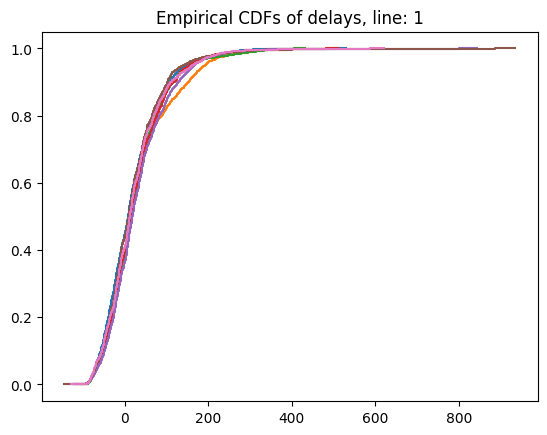

In [149]:
for ecdf in ecdfs:
    ecdf.cdf.plot()
plt.title("Empirical CDFs of delays, line: 1")

In [166]:
def plot_ecdfs(dfs, line):
    ecdfs = []
    for df in dfs:
        sample = df.loc[df['route_short_name'] == line]['diff']
        ecdfs.append(stats.ecdf(sample))
    i = 0
    for ecdf in ecdfs:
        ecdf.cdf.plot(label = f'{i}')
        i = i + 1
    plt.title(f'Empirical CDFs of delays, line: {line}')
    plt.legend()

In [150]:
samples = [x.loc[x['route_short_name']=="1"]['diff'] for x in dfs]

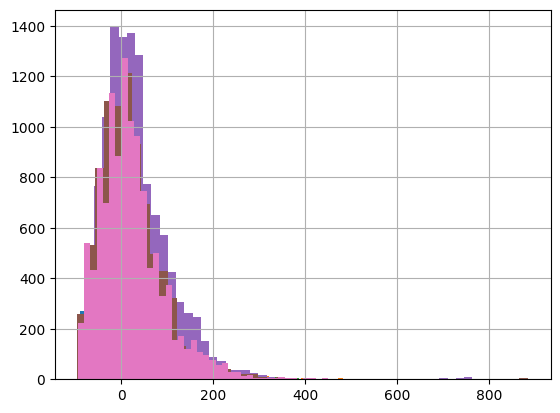

In [151]:
for s in samples:
    s.hist(bins=50)

### Testowanie Kruskallem-Wallisem

In [100]:
stats.kruskal(*samples).statistic

109.47910580343346

In [152]:
intersection = dfs[0]['route_short_name'].unique()
for df in dfs:
    intersection = np.intersect1d(intersection, df['route_short_name'].unique())

In [153]:
h_stat = []
p_val = []
for line in intersection:
    samples = [x.loc[x['route_short_name']==line]['diff'] for x in dfs]
    kruskal = stats.kruskal(*samples)
    h_stat.append(kruskal.statistic)
    p_val.append(kruskal.pvalue)

In [154]:
kruskal_df = pd.DataFrame({"line":intersection, "h_stat":np.array(h_stat), "p-val":np.array(p_val)})

Małe p-val znaczy, że są istotne różnice, niewidoczne na wykresie, zbyt duże próbki?

In [155]:
kruskal_df.sort_values(by="p-val", ascending=False)

,line,h_stat,p-val
281,Z12,6.732233,3.463215e-01
159,379,11.025634,8.758741e-02
224,809,12.487625,5.193377e-02
189,704,13.714950,3.298757e-02
229,900,16.397866,1.177052e-02
...,...,...,...
63,167,1205.644582,2.873393e-257
64,168,1258.946097,8.348964e-269
14,116,1457.925417,0.000000e+00
77,180,1817.572876,0.000000e+00


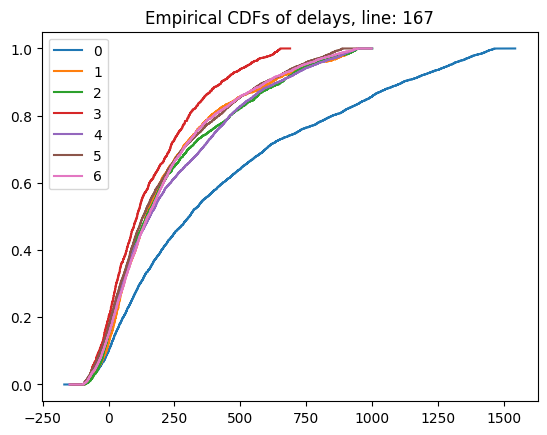

In [167]:
plot_ecdfs(dfs,"167")

Dzień 0 mocno odbiega od reszty więc go wyrzucamy, był to 2 maja - święto

([], [])

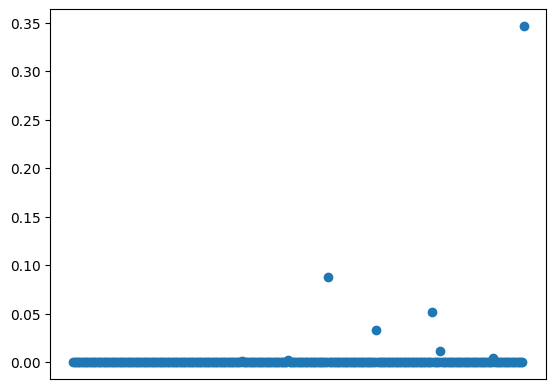

In [168]:
plt.scatter(kruskal_df['line'], kruskal_df['p-val'])
plt.xticks([], [])

#### Bez pierwszego dnia

In [170]:
dates = ['2023-05-09', '2023-05-16', '2023-05-23', '2023-05-30', '2023-06-06', '2023-06-13']

In [171]:
dfs = []
for date in dates:
    dfs.append(get_df(directory, date))

In [172]:
intersection = dfs[0]['route_short_name'].unique()
for df in dfs:
    intersection = np.intersect1d(intersection, df['route_short_name'].unique())

In [173]:
h_stat = []
p_val = []
for line in intersection:
    samples = [x.loc[x['route_short_name']==line]['diff'] for x in dfs]
    kruskal = stats.kruskal(*samples)
    h_stat.append(kruskal.statistic)
    p_val.append(kruskal.pvalue)

In [174]:
kruskal_df = pd.DataFrame({"line":intersection, "h_stat":np.array(h_stat), "p-val":np.array(p_val)})

In [175]:
kruskal_df.sort_values(by="p-val", ascending=False)

,line,h_stat,p-val
281,Z12,6.053659,3.010327e-01
265,L36,8.624551,1.250097e-01
159,379,9.334985,9.642587e-02
224,809,11.381077,4.432649e-02
189,704,12.876119,2.456774e-02
...,...,...,...
217,738,766.631144,1.912313e-163
133,26,768.845713,6.346670e-164
97,20,843.932828,3.615251e-180
93,197,997.634874,1.953985e-213


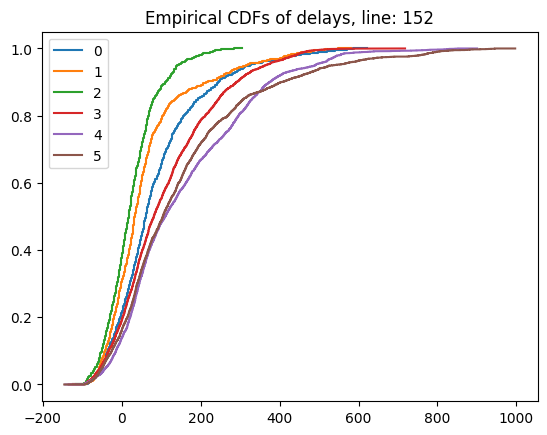

In [176]:
plot_ecdfs(dfs,"152")

([], [])

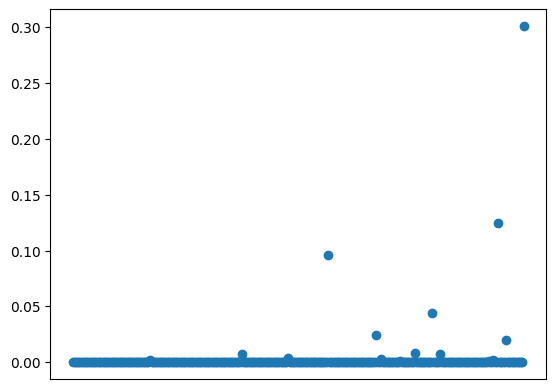

In [177]:
plt.scatter(kruskal_df['line'], kruskal_df['p-val'])
plt.xticks([], [])

In [179]:
kruskal_df.sort_values(by="p-val", ascending=False)['line'][0:10]

281    Z12
265    L36
159    379
224    809
189    704
270    L41
213    733
105    209
229    900
134    262
Name: line, dtype: object

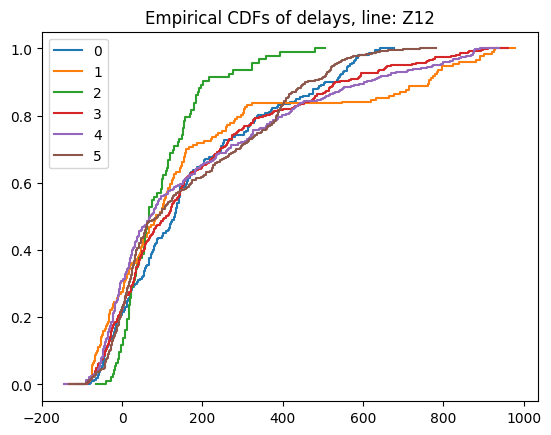

In [193]:
plot_ecdfs(dfs, "Z12")

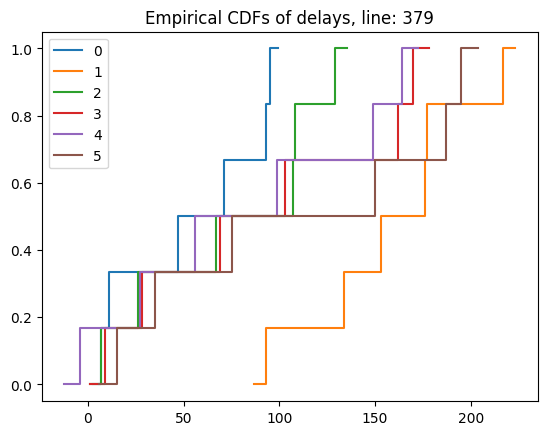

In [194]:
plot_ecdfs(dfs, "379")

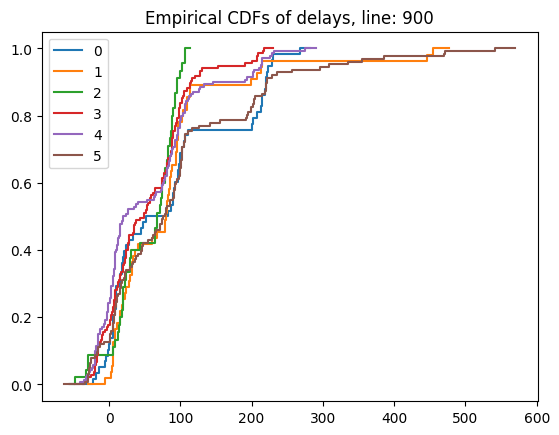

In [195]:
plot_ecdfs(dfs, "900")

In [192]:
kruskal_df.sort_values(by="p-val", ascending=True)['line'][0:10]

49     152
93     197
97      20
133     26
217    738
113     22
29     131
116    222
124     24
86     189
Name: line, dtype: object

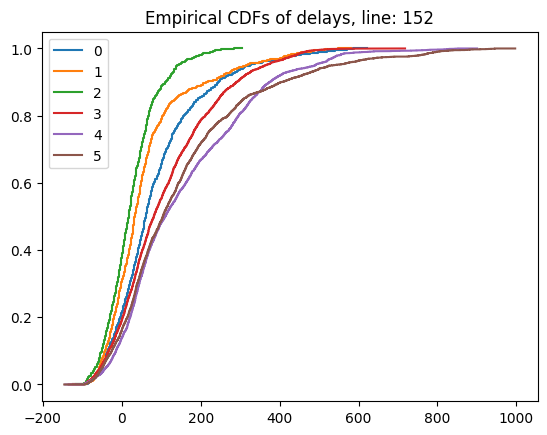

In [196]:
plot_ecdfs(dfs, "152")

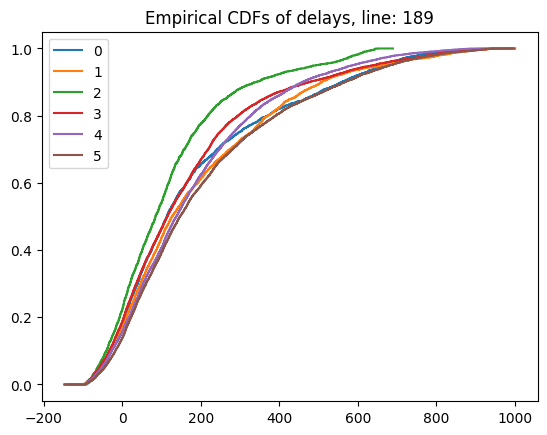

In [197]:
plot_ecdfs(dfs, "189")

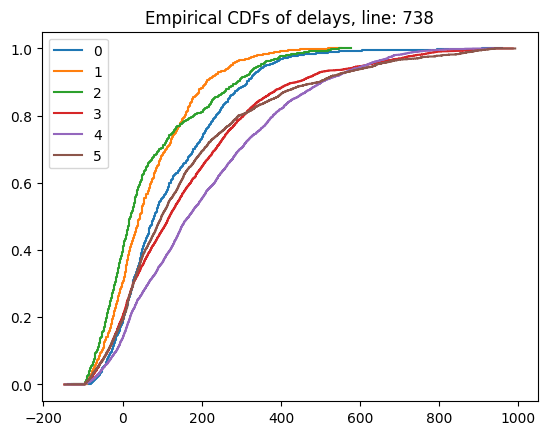

In [198]:
plot_ecdfs(dfs, "738")